In [119]:
import pandas as pd
import numpy as np
from pathlib import Path
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics


In [120]:
git_folder = Path('../..')
figure_folder = git_folder / 'Figures' /'KEIO'
figure_folder.mkdir(parents=True, exist_ok=True)
data_folder_1 = git_folder / 'data' / 'this_project' / '2_keio_strains_screening'
fn_tubes = data_folder_1 / '2A_ecoli_KO_screen_tubes_OD.csv'

uM_fn = data_folder_1 / '2C_exometabolome_uM.csv'

In [121]:
df_uM = pd.read_csv(uM_fn, index_col=0, nrows=27)
# Drop metabolites not detected in any condition
df_uM = df_uM.loc[:, df_uM.notna().any()]

In [122]:
# move pool samples to a separate df
df_uMpools = df_uM.loc[df_uM.Sample_id.str.contains('pool')]
df_uMsamples = df_uM.loc[~df_uM.Sample_id.str.contains('pool')]

In [123]:
df_od_tubes = pd.read_csv(fn_tubes, index_col=0)
df_od_tubes.rename(columns={'Hours': 'Time [h]'}, inplace=True) 

# only keep data fro strains we did exomtabolome on
exo_strains = sorted(df_uMsamples.Strain.unique())

df_od_tubes = df_od_tubes.loc[df_od_tubes.Strain.isin(exo_strains)]

# strains = sorted(df_od_tubes.Strain.unique())
replicates = ['A', 'B', 'C']



# Estimate AUC


In [124]:
df_uM.columns

Index(['Sample_id', 'Phenylalanine', 'Leucine', 'Gamma-aminobutyrate',
       'Proline', 'Valine', 'Beta-alanine', 'Alanine', 'Alpha-aminoadipate',
       'Glycine', 'Glutamine', 'Glutamate', 'Serine', 'Asparagine',
       'Citrulline', 'Aspartate', 'Histidine', 'Lactate',
       'Fructose-6-phosphate', 'Malate', 'Glucose-6-phosphate',
       'Cis-aconitate', 'Citrate', 'Isocitrate', 'Trans-aconitate', 'OD ID',
       'Strain', 'OD', 'Replicate', 'Hours'],
      dtype='object')

In [125]:
auc_data = []

for strain in exo_strains:
    for rep in replicates:
        idx_sample = (df_uMsamples['Strain']==strain)&(df_uMsamples.Replicate==rep)
        sampling_time = df_uMsamples.loc[idx_sample]['Hours'].values[0]
        sampling_od = df_uMsamples.loc[idx_sample]['OD'].values[0]

        idx = (df_od_tubes.Strain == strain) & (df_od_tubes.Replicate == rep) & (df_od_tubes['Time [h]'] <= sampling_time)
        dfs = df_od_tubes.loc[idx, ['Time [h]', 'OD600']].copy()
        dfs.dropna(inplace=True)
        dfs.sort_values(by='Time [h]', inplace=True)

        time = list(dfs['Time [h]'].values)+[sampling_time]
        od = list(dfs['OD600'].values) + [sampling_od]
       
        sampling_auc = metrics.auc(x = time, y = od)
        auc_data.append([strain, rep, sampling_time, sampling_od, sampling_auc])
auc_df = pd.DataFrame(auc_data, columns=['Strain', 'Replicate', 'Sampling time [h]', 'Sample OD', 'AUC'])


In [126]:
# gDW to OD600 - use values emasured in bioreactors
od_to_gdw = 0.346 # gDW/L/OD600
auc_df['AUC [gDW/L*h]'] = auc_df['AUC'] * od_to_gdw

In [127]:
for i, row in df_uMsamples.iterrows():
    strain = row['Strain']
    rep = row['Replicate']
    auc_idx = (auc_df.Strain == strain) & (auc_df.Replicate == rep)
    auc_gdw = auc_df.loc[auc_idx, 'AUC [gDW/L*h]'].values[0]
    df_uMsamples.loc[i, 'AUC [gDW/L*h]'] = auc_gdw
# df_uMsamples['Rate [mmol/gDW/h]'] = df_uMsamples['C

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_49024/4190248048.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uMsamples.loc[i, 'AUC [gDW/L*h]'] = auc_gdw


In [128]:
df_uMsamplesL = df_uMsamples.melt(id_vars=['Sample_id', 'Strain', 'Replicate', 'Hours', 'AUC [gDW/L*h]', 'OD', 'OD ID'],
                    var_name='Metabolite', value_name='Concentration [uM]')


In [129]:
df_uMsamplesL['Rate [mmol/gDW/h]'] = df_uMsamplesL['Concentration [uM]'] *1e-3 / df_uMsamplesL['AUC [gDW/L*h]']

In [130]:
df_rates = df_uMsamplesL.groupby(['Strain', 'Metabolite']).agg({'Rate [mmol/gDW/h]': ('mean', 'std', 'sem')}).reset_index()
df_ratesWT = df_rates.loc[df_rates.Strain == 'WT'].copy()

In [131]:
# df_uMsamples

# Read in rates from batch cultures at SINTEF

In [132]:
data_folder = git_folder / 'data' 
sintef_fn = data_folder / 'this_project' / '1_e_coli_batch_cultures'/'1K_rates_and_values.csv'#'sintef_2023/sintef_2023_rates_1024.csv'
sintef_df = pd.read_csv(sintef_fn, index_col=0)


In [133]:
sintef_df.dropna(subset=['Rate [mmol/gDW/h]'], inplace=True)

In [134]:
sintef_df.columns

Index(['Carbon source', 'Metabolite', 'Slope', 'Intercept', 'r', 'p-value',
       'Std. Err', 'N', 'T3_pval', 'Fitted on', 'Comment', 'Rate [mmol/gDW/h]',
       'Std. Err [mmol/gDW/h]', 'Rate [1/gDW/h]', 'Std. Err [1/gDW/h]',
       'Metabolite value [gDW/mmol]', 'N carbons', 'Mol weight [g/mol]',
       'Turnover [mmol/gDW/h]', 'Model ID', 'MV min', 'MV max', 'Species',
       'Dataset'],
      dtype='object')

In [135]:
sintef_met_rates = sintef_df.loc[sintef_df['Carbon source']=='Galactose'].set_index('Metabolite')['Rate [mmol/gDW/h]'].to_dict()
sintef_met_rates_std = sintef_df.loc[sintef_df['Carbon source']=='Galactose'].set_index('Metabolite')['Std. Err [mmol/gDW/h]'].to_dict()
sintef_met_values = sintef_df.loc[sintef_df['Carbon source']=='Galactose'].set_index('Metabolite')['Metabolite value [gDW/mmol]'].to_dict()

In [136]:
sintef_met_values

{'Acetate': 0.0215371503081318,
 'Alanine': 0.039081170036892,
 'Alpha-aminoadipate': nan,
 'Asparagine': 0.0552476379850175,
 'Aspartate': 0.0446015891692852,
 'Beta-alanine': 0.0442950015420939,
 'Cis-aconitate': 0.0639602902836933,
 'Creatine': nan,
 'Deoxycarnitine (deoxy-c0)': nan,
 'Formate': 0.0066306621797407,
 'Gamma-aminobutyrate': 0.0642757745003996,
 'Glutamate': 0.0633352130622377,
 'Glutarylcarnitine (c5-dc)': nan,
 'Hexoses': nan,
 'Isocitrate': 0.0642128487179261,
 'Isoleucine': 0.1220419139158768,
 'Lactate': 0.0376305265196996,
 'Leucine': 0.1344150914803055,
 'Lysine': 0.1091727584862478,
 'Malate': 0.043120938562513,
 'Methionine': 0.1821036906331341,
 'NAD': 0.373479782828523,
 'Phenylalanine': 0.1502653789880903,
 'Pipecolic acid': nan,
 'Proline': 0.0813185616902356,
 'Sebacoyl-l-carnitine (c10-dc)': nan,
 'Succinate': 0.0465224820244636,
 'Trans-aconitate': 0.0639602902836822,
 'Valine': 0.0903792086637322}

In [137]:
df_ratesWT['Bioreactor rate [mmol/gDW/h]'] = df_ratesWT['Metabolite'].map(sintef_met_rates)
df_ratesWT['Bioreactor rate ste [mmol/gDW/h]'] = df_ratesWT['Metabolite'].map(sintef_met_rates_std)
df_ratesWT['Metabolite value [gDW/mmol]'] = df_ratesWT['Metabolite'].map(sintef_met_values)

In [138]:
df_ratesWT.columns = ['Strain', 'Metabolite', 'Rate [mmol/gDW/h]', 'Rate std [mmol/gDW/h]', 'Rate sem [mmol/gDW/h]', 'Bioreactor rate [mmol/gDW/h]', 'Bioreactor rate sem [mmol/gDW/h]', 'Metabolite value [gDW/mmol]']

In [161]:
metabolites = df_ratesWT['Metabolite'].unique()
cmap = plt.get_cmap('tab20')
color_dict = {met: cmap(i % 20) for i, met in enumerate(metabolites)}


Skipping Alanine due to non-positive rates: SF 0.0006191674536254283, BR -0.0005832213060638
Skipping Asparagine due to non-positive rates: SF nan, BR -0.0001275852261206
Skipping Citrate due to non-positive rates: SF 0.006160260086960524, BR nan
Skipping Citrulline due to non-positive rates: SF nan, BR nan
Skipping Fructose-6-phosphate due to non-positive rates: SF 0.0037971137130095797, BR nan
Skipping Glucose-6-phosphate due to non-positive rates: SF nan, BR nan
Skipping Glutamine due to non-positive rates: SF nan, BR nan
Skipping Glycine due to non-positive rates: SF nan, BR nan
Skipping Histidine due to non-positive rates: SF nan, BR nan
Skipping Lactate due to non-positive rates: SF 0.0011236095871440712, BR -0.0001574116795548
Skipping Phenylalanine due to non-positive rates: SF nan, BR 1.2177108158589878e-05
Skipping Proline due to non-positive rates: SF nan, BR 3.798474846007428e-06
Skipping Serine due to non-positive rates: SF nan, BR nan
Skipping Valine due to non-positive r

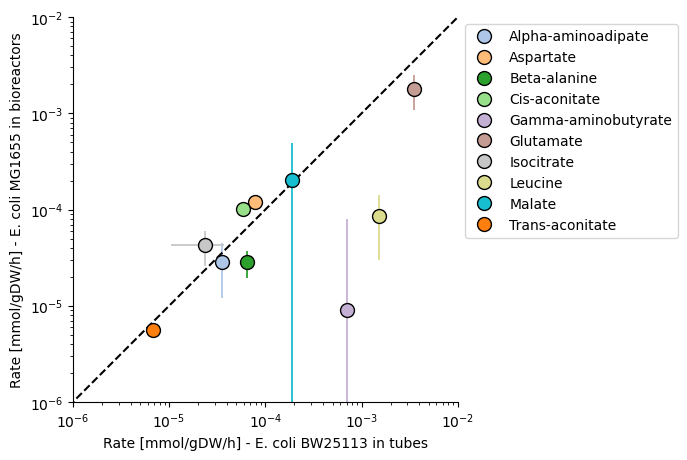

In [219]:
fig, ax = plt.subplots(figsize=(6, 5))
for i, row in df_ratesWT.iterrows():
    br_rate = row['Bioreactor rate [mmol/gDW/h]']
    br_sem = row['Bioreactor rate sem [mmol/gDW/h]']
    sf_rate = row['Rate [mmol/gDW/h]']
    sf_sem = row['Rate sem [mmol/gDW/h]']

    if (br_rate > 0) & (sf_rate > 0):
        ax.errorbar(x = sf_rate, xerr=sf_sem,
              y = br_rate, yerr = br_sem,
              label = row['Metabolite'],
              markeredgecolor = 'black', linewidth=1,
              markersize=10,
              elinewidth=1.3,
              ls = 'none', marker='o', color = color_dict[row['Metabolite']],)
    else:
        print(f"Skipping {row['Metabolite']} due to non-positive rates: SF {sf_rate}, BR {br_rate}")
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.xlabel(f'Rate [mmol/gDW/h] - E. coli BW25113 in tubes')
plt.ylabel('Rate [mmol/gDW/h] - E. coli MG1655 in bioreactors')
# plt.title('Rates for E. coli BW25113 in shake flask vs MG1655 in bioreactors')
plt.plot([0, 1], [0, 1], 'k--')
sns.despine()
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-6, 1e-2)
plt.ylim(1e-6, 1e-2)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(figure_folder / '2B_ecoli_BW25113_rates_vs_bioreactor.pdf', bbox_inches='tight')

Alanine 0.039081170036892 0.0006191674536254283 1.6715207447183067e-05
Aspartate 0.0446015891692852 7.812922852881196e-05 6.9453627490416316e-06
Beta-alanine 0.0442950015420939 6.394862357164433e-05 1.904070343475069e-06
Cis-aconitate 0.0639602902836933 5.8665102074788144e-05 3.822160293208732e-06
Gamma-aminobutyrate 0.0642757745003996 0.0007035936419362088 8.226211375184463e-05
Glutamate 0.0633352130622377 0.0034910320335621004 0.00023381903343668806
Isocitrate 0.0642128487179261 2.3881160438268902e-05 1.3393317146256521e-05
Lactate 0.0376305265196996 0.0011236095871440712 0.0002892089641354053
Leucine 0.1344150914803055 0.0015332168623388087 1.7620734539479582e-05
Malate 0.043120938562513 0.00018977928459510353 6.967805201660764e-06
Trans-aconitate 0.0639602902836822 6.858463900779021e-06 4.998728692293798e-07


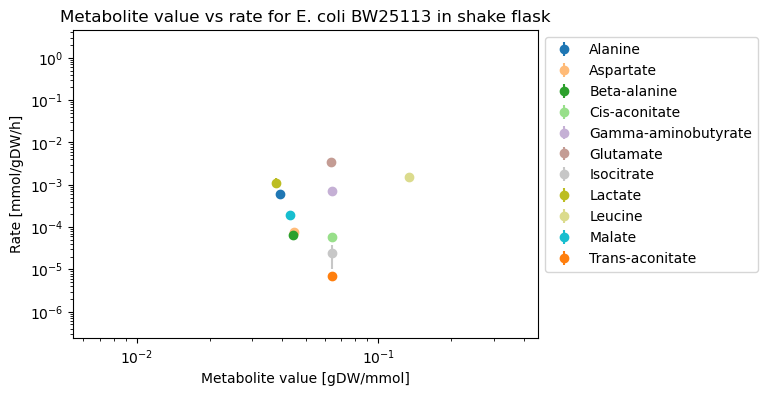

In [177]:
xarr = []
yarr = []
fig, ax = plt.subplots(figsize=(6, 4))
for i, row in df_ratesWT.iterrows():
    sf_rate = row['Rate [mmol/gDW/h]']
    sf_sem = row['Rate sem [mmol/gDW/h]']
    sf_value = row['Metabolite value [gDW/mmol]']
    if (sf_rate > 0) and (sf_value > 0):

        print(row['Metabolite'], sf_value, sf_rate, sf_sem)
        xarr.append(sf_value)
        yarr.append(sf_rate)
        ax.errorbar(y = sf_rate, yerr=sf_sem,
              x = sf_value,
              label = row['Metabolite'],
              ls = 'none', marker='o',
              color = color_dict[row['Metabolite']],)
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Metabolite value [gDW/mmol]')
plt.ylabel('Rate [mmol/gDW/h]')
plt.title('Metabolite value vs rate for E. coli BW25113 in shake flask')

plt.xlim(np.float64(0.00542027588560326), np.float64(0.45688048416067667))
plt.ylim(np.float64(2.3765068572093932e-07), np.float64(4.530248811038241))
plt.yscale('log')
plt.xscale('log')



Alanine 0.039081170036892 0.0006191674536254283 1.6715207447183067e-05
Aspartate 0.0446015891692852 7.812922852881196e-05 6.9453627490416316e-06
Beta-alanine 0.0442950015420939 6.394862357164433e-05 1.904070343475069e-06
Cis-aconitate 0.0639602902836933 5.8665102074788144e-05 3.822160293208732e-06
Gamma-aminobutyrate 0.0642757745003996 0.0007035936419362088 8.226211375184463e-05
Glutamate 0.0633352130622377 0.0034910320335621004 0.00023381903343668806
Isocitrate 0.0642128487179261 2.3881160438268902e-05 1.3393317146256521e-05
Lactate 0.0376305265196996 0.0011236095871440712 0.0002892089641354053
Leucine 0.1344150914803055 0.0015332168623388087 1.7620734539479582e-05
Malate 0.043120938562513 0.00018977928459510353 6.967805201660764e-06
Trans-aconitate 0.0639602902836822 6.858463900779021e-06 4.998728692293798e-07
Acetate 0.0215371503081318 0.2037245636129564 0.1067708730988282
Aspartate 0.0446015891692852 0.0001207495262639 1.6477292772447458e-05
Beta-alanine 0.0442950015420939 2.828017

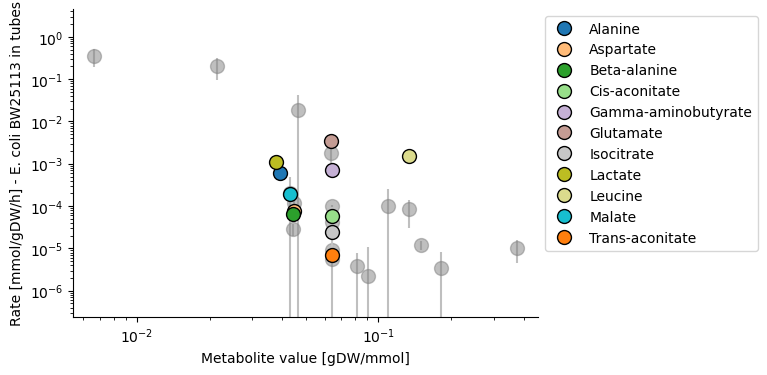

In [222]:
xarr = []
yarr = []
fig, ax = plt.subplots(figsize=(6, 4))
for i, row in df_ratesWT.iterrows():
    sf_rate = row['Rate [mmol/gDW/h]']
    sf_sem = row['Rate sem [mmol/gDW/h]']
    sf_value = row['Metabolite value [gDW/mmol]']
    if (sf_rate > 0) and (sf_value > 0):

        print(row['Metabolite'], sf_value, sf_rate, sf_sem)
        xarr.append(sf_value)
        yarr.append(sf_rate)
        ax.errorbar(y = sf_rate, yerr=sf_sem,
              x = sf_value,
              label = row['Metabolite'],
              ls = 'none', marker='o',
              markersize=10,
              elinewidth=1.3,
              markeredgecolor = 'black', #linewidth=0.5,
              color = color_dict[row['Metabolite']])

for i, row in sintef_df.loc[sintef_df['Carbon source']=='Galactose'].iterrows():
    br_rate = row['Rate [mmol/gDW/h]']
    br_sem = row['Std. Err [mmol/gDW/h]']
    br_value = row['Metabolite value [gDW/mmol]']
    if (br_rate > 0) and (br_value > 0):
        print(row['Metabolite'], br_value, br_rate, br_sem)
        ax.errorbar(y = br_rate, yerr=br_sem,
              x = br_value,
              label = None,
              ls = 'none', marker='o',
              markersize=10,
              color = 'gray',alpha = 0.5, zorder = 0,)     

plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Metabolite value [gDW/mmol]')
plt.ylabel(f'Rate [mmol/gDW/h] - E. coli BW25113 in tubes')
# plt.title('Metabolite value vs rate for E. coli BW25113 in shake flask')

plt.xlim(np.float64(0.00542027588560326), np.float64(0.45688048416067667))
plt.ylim(np.float64(2.3765068572093932e-07), np.float64(4.530248811038241))
plt.yscale('log')
plt.xscale('log')
sns.despine()
plt.savefig(figure_folder / '2B_ecoli_BW25113_rates_vs_values.pdf', bbox_inches='tight')



In [172]:
st.spearmanr(xarr, yarr)

SignificanceResult(statistic=np.float64(-0.38181818181818183), pvalue=np.float64(0.27625533338543595))